# Test case 2D-2 (unsteady)

In [1]:
import numpy as np
import time
import scipy.sparse.linalg as sp_la
import matplotlib.pyplot as plt
import numba
import os

# --- Numba configuration ---
try:
    num_cores = os.cpu_count()
    numba.set_num_threads(num_cores)
    print(f"Numba is set to use {numba.get_num_threads()} threads.")
except (ImportError, AttributeError):
    print("Numba not found or configured. Running in pure Python mode.")

# --- Core pycutfem imports ---
from pycutfem.core.mesh import Mesh
from pycutfem.core.dofhandler import DofHandler
from pycutfem.utils.meshgen import structured_quad
from pycutfem.fem.mixedelement import MixedElement
from pycutfem.core.levelset import CircleLevelSet
from pycutfem.utils.domain_manager import get_domain_bitset

# --- UFL-like imports ---
from pycutfem.ufl.functionspace import FunctionSpace
from pycutfem.ufl.expressions import (
    TrialFunction, TestFunction, VectorTrialFunction, VectorTestFunction,
    Function, VectorFunction, Constant, grad, inner, dot, div, jump, avg, FacetNormal, CellDiameter
)
from pycutfem.ufl.measures import dx, dS, dGhost, dInterface
from pycutfem.ufl.forms import BoundaryCondition, Equation
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters
from pycutfem.ufl.compilers import FormCompiler

Numba: Using NumPy 2.1.3 (/home/bhatti/anaconda3/envs/pycutfem/lib/python3.13/site-packages/numpy/__init__.py)
numpy_version: (2, 1)
Numba is set to use 16 threads.


In [2]:
# ============================================================================
#    1. BENCHMARK PROBLEM SETUP
# ============================================================================
print("--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---")

# --- Geometry and Fluid Properties ---
H = 0.41  # Channel height
L = 2.2   # Channel length
D = 0.1   # Cylinder diameter
c_x, c_y = 0.2, 0.2  # Cylinder center
rho = 1.0  # Density
mu = 1e-3  # Viscosity
U_mean = 1.0  # Mean inflow velocity
Re = rho * U_mean * D / mu
print(f"Reynolds number (Re): {Re:.2f}")

--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---
Reynolds number (Re): 100.00


In [3]:
# from pycutfem.utils.adaptive_mesh import structured_quad_levelset_adaptive
from pycutfem.utils.adaptive_mesh_ls_numba import structured_quad_levelset_adaptive
# --- Mesh ---
# A finer mesh is needed for this benchmark
NX, NY = 40, 40
# NX, NY = 30, 40
poly_order = 2
level_set = CircleLevelSet(center=(c_x, c_y), radius=D/2.0 ) # needs to correct the radius, also cx modified for debugging
# h  = 0.5*(L/NX + H/NY)


# nodes, elems, _, corners = structured_quad(L, H, nx=NX, ny=NY, poly_order=poly_order)

nodes, elems, edges, corners = structured_quad_levelset_adaptive(
        Lx=L, Ly=H, nx=NX, ny=NY, poly_order=poly_order,
        level_set=CircleLevelSet(center=(c_x, c_y), radius=(D/2.0+0.2*D/2.0) ),
        max_refine_level=1)          # add a single halo, nothing else
mesh = Mesh(nodes=nodes, element_connectivity=elems, elements_corner_nodes=corners, element_type="quad", poly_order=poly_order)

# ============================================================================
#    2. BOUNDARY CONDITIONS
# ============================================================================

# --- Tag Boundaries ---

bc_tags = {
    'inlet':  lambda x, y: np.isclose(x, 0),
    'outlet': lambda x, y: np.isclose(x, L),
    'walls':  lambda x, y: np.isclose(y, 0) | np.isclose(y, H),
}



# --- Define Parabolic Inflow Profile ---
def parabolic_inflow(x, y):
    return 4 * U_mean * y * (H - y) / (H**2)

# --- Define Boundary Conditions List ---
bcs = [
    BoundaryCondition('ux', 'dirichlet', 'inlet', parabolic_inflow),
    BoundaryCondition('uy', 'dirichlet', 'inlet', lambda x, y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'walls', lambda x, y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'walls', lambda x, y: 0.0),
    # No-slip on the cylinder is handled by the CutFEM formulation
    # "Do-nothing" at the outlet is the natural BC
]

# Homogeneous BCs for Jacobian assembly
bcs_homog = [BoundaryCondition(bc.field, bc.method, bc.domain_tag, lambda x, y: 0.0) for bc in bcs]



In [4]:
# --- Level Set for the Cylinder Obstacle ---
mesh.classify_elements(level_set)
mesh.classify_edges(level_set)
mesh.build_interface_segments(level_set=level_set)
mesh.tag_boundary_edges(bc_tags)

# --- Define Domains with BitSets ---
fluid_domain = get_domain_bitset(mesh, "element", "outside")
rigid_domain = get_domain_bitset(mesh, "element", "inside")
cut_domain = get_domain_bitset(mesh, "element", "cut")
ghost_edges = mesh.edge_bitset('ghost')
physical_domain = fluid_domain | cut_domain

# --- Finite Element Space and DofHandler ---
# Taylor-Hood elements (Q2 for velocity, Q1 for pressure)
mixed_element = MixedElement(mesh, field_specs={'ux': 2, 'uy': 2, 'p': 1})
dof_handler = DofHandler(mixed_element, method='cg')
dof_handler.info()

print(f"Number of interface edges: {mesh.edge_bitset('interface').cardinality()}")
print(f"Number of ghost edges: {mesh.edge_bitset('ghost').cardinality()}")
print(f"Number of cut elements: {cut_domain.cardinality()}")
print(f"Number of pos ghost edges: {mesh.edge_bitset('ghost_pos').cardinality()}")
print(f"Number of neg ghost edges: {mesh.edge_bitset('ghost_neg').cardinality()}")
print(f"Number of ghost edges (both): {mesh.edge_bitset('ghost_both').cardinality()}")


=== DofHandler (CG) ===
        ux: 9309 DOFs @ offset 0
        uy: 9309 DOFs @ offset 9
         p: 2376 DOFs @ offset 18
  total : 20994
Number of interface edges: 46
Number of ghost edges: 90
Number of cut elements: 46
Number of pos ghost edges: 50
Number of neg ghost edges: 38
Number of ghost edges (both): 2


In [5]:
# 1. Define the target point.
target_point = np.array([1.5, 0.99 * H])

# 2. Get all node IDs that have a pressure DOF associated with them.
p_dofs = dof_handler.get_field_slice('p')
p_node_ids = np.array([dof_handler._dof_to_node_map[dof][1] for dof in p_dofs])

# 3. Get the coordinates of ONLY these pressure-carrying nodes.
p_node_coords = mesh.nodes_x_y_pos[p_node_ids]

# 4. Find the node closest to the target point WITHIN this restricted set.
distances = np.linalg.norm(p_node_coords - target_point, axis=1)
local_index = np.argmin(distances)

# 5. Get the global ID and actual coordinates of that specific pressure node.
closest_p_node_id = p_node_ids[local_index]
actual_pin_coords = mesh.nodes_x_y_pos[closest_p_node_id]
print(f"Pinning pressure at the node closest to {target_point}, found at {actual_pin_coords}")


Pinning pressure at the node closest to [1.5    0.4059], found at [1.485 0.41 ]


In [6]:
# dof_handler.tag_dof_by_locator(
#     'p_pin', 'p',
#     locator=lambda x, y: np.isclose(x, actual_pin_coords[0]) and np.isclose(y, actual_pin_coords[1]),
#     find_first=True
# )
# bcs.append(BoundaryCondition('p', 'dirichlet', 'p_pin', lambda x, y: 0.0))
# bcs_homog.append(BoundaryCondition('p', 'dirichlet', 'p_pin', lambda x, y: 0.0))
# Tag velocity DOFs inside the cylinder (same tag name for both fields is OK)
dof_handler.tag_dofs_from_element_bitset("inactive", "ux", "inside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "uy", "inside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "p", "inside", strict=True)

bcs.append(BoundaryCondition('ux', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs.append(BoundaryCondition('uy', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs.append(BoundaryCondition('p', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs_homog.append(BoundaryCondition('ux', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs_homog.append(BoundaryCondition('uy', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs_homog.append(BoundaryCondition('p', 'dirichlet', 'inactive', lambda x, y: 0.0))

In [7]:
for name, bitset in mesh._edge_bitsets.items():
    print(f"Edge bitset '{name}': {bitset.cardinality()}")

Edge bitset 'ghost_both': 2
Edge bitset 'ghost_neg': 38
Edge bitset 'ghost_pos': 50
Edge bitset 'interface': 46
Edge bitset 'ghost': 90
Edge bitset 'inlet': 53
Edge bitset 'outlet': 53
Edge bitset 'walls': 86


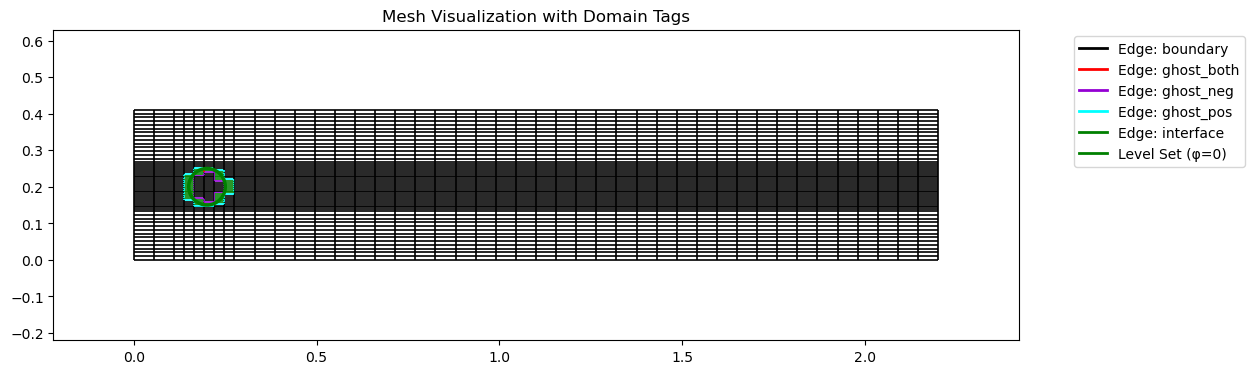

<Axes: title={'center': 'Mesh Visualization with Domain Tags'}>

In [8]:
from pycutfem.io.visualization import plot_mesh_2
fig, ax = plt.subplots(figsize=(15, 30))
plot_mesh_2(mesh, ax=ax, level_set=level_set, show=True, 
              plot_nodes=False, elem_tags=False, edge_colors=True, plot_interface=False,resolution=300)

In [9]:
# ============================================================================
#    3. UFL FORMULATION WITH GHOST PENALTY
# ============================================================================
print("\n--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---")

# --- Function Spaces and Functions ---
velocity_space = FunctionSpace(name="velocity", field_names=['ux', 'uy'],dim=1)
pressure_space = FunctionSpace(name="pressure", field_names=['p'], dim=0)

# Trial and Test functions
du = VectorTrialFunction(space=velocity_space, dof_handler=dof_handler)
dp = TrialFunction(name='trial_pressure', field_name='p', dof_handler=dof_handler)
v = VectorTestFunction(space=velocity_space, dof_handler=dof_handler)
q = TestFunction(name='test_pressure', field_name='p', dof_handler=dof_handler)

# Solution functions at current (k) and previous (n) time steps
u_k = VectorFunction(name="u_k", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_k = Function(name="p_k", field_name='p', dof_handler=dof_handler)
u_n = VectorFunction(name="u_n", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_n = Function(name="p_n", field_name='p', dof_handler=dof_handler)

# --- Parameters ---
dt = Constant(0.02)
theta = Constant(1.0) # Crank-Nicolson
mu_const = Constant(mu)
rho_const = Constant(rho)

u_k.nodal_values.fill(0.0); p_k.nodal_values.fill(0.0)
u_n.nodal_values.fill(0.0); p_n.nodal_values.fill(0.0)
dof_handler.apply_bcs(bcs, u_n, p_n)


--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---


Plotting all components of 'u_n' as separate contour plots...


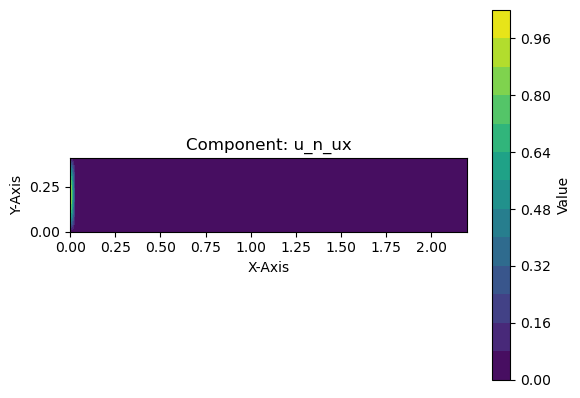

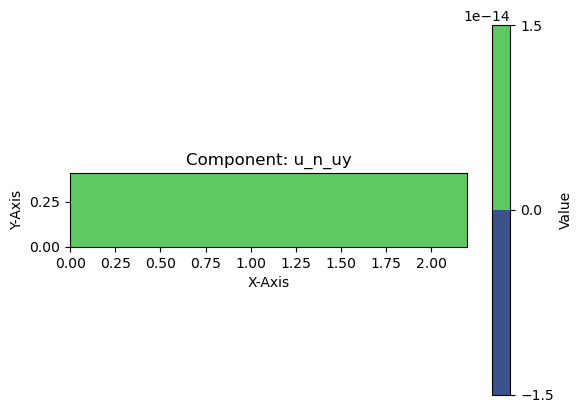

In [10]:
u_n.plot()

In [11]:
print(len(dof_handler.get_dirichlet_data(bcs)))

772


In [12]:
import numpy as np

def make_peak_filter_cb(
    dh,
    level_set,
    *,
    fields=('ux', 'uy'),
    side='+',                 # '+' → φ>=0 (outside), '-' → φ<=0 (inside)
    band_width=1.0,           # keep nodes with |φ| <= band_width * h_dof
    tau=3.5,                  # MAD threshold
    skip_dofs=None            # set[int] of global DOFs to skip (e.g. active Dirichlet)
):
    """
    Robust outlier clamp for velocity components near the interface, operating in
    DOF space using only the DofHandler's numbering and maps.

    Usage:
        skip_active = set(dh.get_dirichlet_data(bcs).keys()) \
                      - set(dh.dof_tags.get('inactive', set()))
        cb = make_peak_filter_cb(dh, level_set, side='+', band_width=1.0,
                                 tau=3.5, skip_dofs=skip_active)
        solver = NewtonSolver(..., post_cb=cb)
    """
    if skip_dofs is None:
        skip_dofs = set()

    mesh = dh.mixed_element.mesh

    # -----------------------------------------------------------
    # 1) Build 1-ring DOF adjacency per field from element maps
    # -----------------------------------------------------------
    def _build_dof_adjacency(field):
        adj = {}  # gdof -> set(neighbour gdofs)
        elem_maps = dh.element_maps[field]            # per-element global DOFs (field)
        for gdofs in elem_maps:                       # list[int] for that element/field
            g = list(gdofs)
            for i in range(len(g)):
                ai = g[i]
                s = adj.setdefault(ai, set())
                for j in range(len(g)):
                    if i == j: continue
                    s.add(g[j])
        return adj

    adj_by_field = {f: _build_dof_adjacency(f) for f in fields}

    # -----------------------------------------------------------
    # 2) Coordinates and φ at DOFs (handler-driven, not mesh ids)
    # -----------------------------------------------------------
    # all DOF coords aligned with global DOF index
    all_coords = dh.get_all_dof_coords()             # shape (total_dofs, 2)  :contentReference[oaicite:11]{index=11}
    # φ evaluated vectorised (CircleLevelSet etc. support array input)
    phi_all = level_set(all_coords)

    # -----------------------------------------------------------
    # 3) Per-DOF h: mean element char length over adjacent elems
    # -----------------------------------------------------------
    # Build node -> {adjacent element ids} once (geometry graph),
    # then map gdof -> node id -> elems -> average h
    node_to_elems = {}
    for el in mesh.elements_list:
        for nid in el.nodes:
            node_to_elems.setdefault(nid, set()).add(el.id)

    g2n = dh._dof_to_node_map  # global dof -> (field, node_id)  :contentReference[oaicite:12]{index=12}

    def _h_for_gdof(gd):
        nid = g2n[gd][1]
        eids = node_to_elems.get(nid, ())
        if not eids:
            return mesh.element_char_length(0)
        return np.mean([mesh.element_char_length(e) for e in eids])

    # cache per-DOF h in a dict (sparse – only what we touch)
    h_cache = {}

    # -----------------------------------------------------------
    # 4) Band masks per field (by DOF), with side selection
    # -----------------------------------------------------------
    def _band_mask_for_field(field):
        gdofs = dh.get_field_slice(field)            # ascending global DOFs  :contentReference[oaicite:13]{index=13}
        phi_f = phi_all[gdofs]
        if side == '+':
            side_ok = (phi_f >= 0.0)
        elif side == '-':
            side_ok = (phi_f <= 0.0)
        else:
            raise ValueError("side must be '+' or '-'")
        # build h per gdof lazily
        h_f = np.empty_like(phi_f)
        for i, gd in enumerate(gdofs):
            if gd not in h_cache:
                h_cache[gd] = _h_for_gdof(gd)
            h_f[i] = h_cache[gd]
        band = (np.abs(phi_f) <= band_width * h_f) & side_ok
        return gdofs, band

    band_by_field = {f: _band_mask_for_field(f) for f in fields}

    # -----------------------------------------------------------
    # 5) The actual filter that edits a VectorFunction in-place
    # -----------------------------------------------------------
    from pycutfem.ufl.expressions import VectorFunction

    def _filter_on_vector(vf, field):
        gdofs, band = band_by_field[field]
        g2l = vf._g2l        # global→local map in that VectorFunction  :contentReference[oaicite:14]{index=14}
        vals = vf.nodal_values

        adj = adj_by_field[field]
        changed = 0

        # iterate only DOFs present in vf and within the band and not in skip list
        for gd, keep in zip(gdofs, band):
            if not keep:               # not in |φ|<=band_width*h or wrong side
                continue
            if gd in skip_dofs:        # e.g. active Dirichlet at walls/inlet/outlet
                continue
            li = g2l.get(gd, None)
            if li is None:             # vf may not carry this DOF (shouldn't happen)
                continue

            neigh = [n for n in adj.get(gd, ()) if n in g2l]
            if len(neigh) < 3:
                continue

            nvals = np.array([vals[g2l[n]] for n in neigh], float)
            med   = np.median(nvals)
            mad   = np.median(np.abs(nvals - med)) + 1e-14
            if abs(vals[li] - med) > tau * mad:
                vals[li] = med
                changed += 1
                dh._tmp_clamped_gdofs.add(gd)   # << NEW, remember this clamped gdof
                dh._tmp_clamped_vals[gd] = med         # NEW
        return changed

    # -----------------------------------------------------------
    # 6) The callback the Newton solver will call each iteration
    # -----------------------------------------------------------
    def _cb(funcs):
        # Reset a per-call scratch set the solver can read afterwards
        dh._tmp_clamped_gdofs = set()     # << NEW
        dh._tmp_clamped_vals = {}
        # Expect a VectorFunction (velocity) and a scalar Function (pressure) in funcs.
        from pycutfem.ufl.expressions import VectorFunction
        vf = next((f for f in funcs if isinstance(f, VectorFunction)), None)
        if vf is None:
            return
        total = 0
        for f in fields:
            total += _filter_on_vector(vf, f)
        if total:
            print(f"        [peak-filter] clamped {total} DOFs in |φ|≤{band_width}h on side '{side}'")

    return _cb


In [ ]:
from pycutfem.ufl.expressions import Derivative, FacetNormal, restrict
from pycutfem.core.geometry import hansbo_cut_ratio
from pycutfem.ufl.expressions import ElementWiseConstant

n = FacetNormal()                    # vector expression (n_x, n_y)
n_f = FacetNormal()                  # vector expression (n_x, n_y) on the fluid side

def _dn(expr):
    """Normal derivative  n·∇expr  on an (interior) edge."""
    Dx = Derivative(expr, 1, 0)
    Dy = Derivative(expr, 0, 1)
    _ = Dx + Dy
    return n[0]*Dx + n[1]*Dy

def grad_inner(u, v):
    """⟨∂ₙu, ∂ₙv⟩  (scalar or 2‑D vector)."""
    if getattr(u, "num_components", 1) == 1:      # scalar
        return _dn(u) * _dn(v)

    if u.num_components == v.num_components == 2: # vector
        return _dn(u[0]) * _dn(v[0]) + _dn(u[1]) * _dn(v[1])

    raise ValueError("grad_inner supports only scalars or 2‑D vectors.")

def hessian_inner(u, v):
    if getattr(u, "num_components", 1) == 1:      # scalar
        return _hess_comp(u, v)

    # vector: sum component-wise
    return sum(_hess_comp(u[i], v[i]) for i in range(u.num_components))


def _hess_comp(a, b):
    return (Derivative(a,2,0)*Derivative(b,2,0) +
            2*Derivative(a,1,1)*Derivative(b,1,1) +
            Derivative(a,0,2)*Derivative(b,0,2))



ghost_edges_used = mesh.edge_bitset('ghost_pos') | mesh.edge_bitset('ghost_both') | mesh.edge_bitset('interface')
dx_phys  = dx(defined_on=physical_domain, 
              level_set=level_set,            # the cylinder level set
              metadata   = {"q": 5, "side": "+"} # integrate only φ>0 (positive side)
    )
dΓ        = dInterface(defined_on=mesh.element_bitset('cut'), level_set=level_set, metadata={"q":5})   # interior surface
dG       = dGhost(defined_on=ghost_edges_used, level_set=level_set,metadata={"q":5,'derivs': {(0,0),(0,1),(1,0),(2,0),(0,2),(1,1)}})  # ghost surface

cell_h  = CellDiameter() # length‑scale per element
beta_N  = Constant(20.0 * poly_order**2)      # Nitsche penalty (tweak)
def scaled_penalty_interface(penalty,poly_order =poly_order,
                             side='+'):
    # 1) Hansbo factor — this is a *numpy array*, one value per element
    beta0_val  = penalty * poly_order**2
    theta_min  = 1.0e-3
    hansbo_plus = hansbo_cut_ratio(mesh, level_set, side=side)    # -> np.ndarray, shape (n_elem,)
    hansbo_plus = np.clip(hansbo_plus, theta_min, 1.0)
    alpha = 0.5
    beta_hansbo_arr = beta0_val * hansbo_plus**(-alpha)
    β_visc = ElementWiseConstant(beta_hansbo_arr) * (mu_const / cell_h)
    β_iner = beta0_val * (rho_const * cell_h / dt)        # no θ-scaling here

    # 3) Final penalty (symbolic EWC × expression)
    return β_visc + β_iner
β = scaled_penalty_interface(30.0, side='+')  # Nitsche penalty

def epsilon(u):
    "Symmetric gradient."
    return 0.5 * (grad(u) + grad(u).T)



def sigma_dot_n_v(u_vec, p_scal,v_test,n):
    """
    Expanded form of (σ(u, p) · n) without using the '@' operator.

        σ(u, p)·n = μ (∇u + ∇uᵀ)·n  −  p n
    """
    # first term: μ (∇u)·n
    a = dot(grad(u_vec), n)
    # second term: μ (∇uᵀ)·n
    b = dot(grad(u_vec).T, n)
    # combine and subtract pressure part
    return  mu * dot((a + b),v_test) - p_scal * dot(v_test,n)         # vector of size 2

# --- Jacobian contribution on Γsolid --------------------------------
J_int = (
    - sigma_dot_n_v(du, dp, v,n_f)           # consistency
    - sigma_dot_n_v(v, q, du,n_f)           # symmetry
    # + beta_N  / cell_h * dot(du, v)     # penalty
    # - dot(du,n) * q
    # + beta_N/ cell_h * dot(du,n) * dot(v,n)     # penalty
    + β  * dot(du, v)     # penalty
) * dΓ

# --- Residual contribution on Γsolid --------------------------------
R_int = (
    - sigma_dot_n_v(u_k, p_k, v,n_f)
    - sigma_dot_n_v(v, q, u_k,n_f)
    # + beta_N  / cell_h * dot(u_k, v)
    # - dot(u_k,n) * q
    # + beta_N/ cell_h * dot(u_k,n) * dot(v,n)
    + β  * dot(u_k, v)  
) * dΓ

# volume ------------------------------------------------------------
# a_vol = restrict(( rho*dot(du,v)/dt
#           + theta*rho*dot(dot(grad(u_k), du), v)
#           + theta*rho*dot(dot(grad(du), u_k), v)
#           + theta*mu*inner(grad(du), grad(v))
#           - dp*div(v) + q*div(du) ),physical_domain) * dx_phys

# r_vol = restrict(( rho*dot(u_k-u_n, v)/dt
#           + theta*rho*dot(dot(grad(u_k), u_k), v)
#           + (1-theta)*rho*dot(dot(grad(u_n), u_n), v)
#           + theta*mu*inner(grad(u_k), grad(v))
#           + (1-theta)*mu*inner(grad(u_n), grad(v))
#           - p_k*div(v) + q*div(u_k) ),physical_domain) * dx_phys
a_vol = ( rho*dot(du,v)/dt
          + theta*rho*dot(dot(grad(u_k), du), v)
          + theta*rho*dot(dot(grad(du), u_k), v)
          + 2 * theta*mu*inner(epsilon(du), epsilon(v))
          - dp*div(v) + q*div(du) ) * dx_phys

r_vol = ( rho*dot(u_k-u_n, v)/dt
          + theta*rho*dot(dot(grad(u_k), u_k), v)
          + (1-theta)*rho*dot(dot(grad(u_n), u_n), v)
          + 2 * theta*mu*inner(epsilon(u_k), epsilon(v))
          + 2 * (1-theta)*mu*inner(epsilon(u_n), epsilon(v))
          - p_k*div(v) + q*div(u_k) ) * dx_phys
          
# ghost stabilisation (add exactly as in your Poisson tests) --------
penalty_val = 1e-3
penalty_grad = 1e-3
penalty_hess = 1e-3
gamma_v = Constant(penalty_val * poly_order**2)
gamma_v_grad= Constant(penalty_grad * poly_order**2)
gamma_p  = Constant(penalty_val * poly_order**1)
gamma_p_grad = Constant(penalty_grad * poly_order**1)
gamma_v_hess = Constant(penalty_hess * poly_order**2)

stab = ( gamma_v  / cell_h   * dot(jump(u_k), jump(v))
       + gamma_v_grad * cell_h   * grad_inner(jump(u_k), jump(v))
         + gamma_v_hess * cell_h**3.0/4.0   * hessian_inner(jump(u_k), jump(v))
    #    + gamma_p  / cell_h   * jump(p_k) * jump(q)  # Note: use * for scalars, see issue 2
       + gamma_p_grad * cell_h**3.0   * grad_inner(jump(p_k), jump(q)) ) * dG

stab_lin  = ( gamma_v  / cell_h   * dot(jump(du),  jump(v)) +
             gamma_v_grad * cell_h   * grad_inner(jump(du),  jump(v)) 
           + gamma_v_hess * cell_h**3.0/4.0   * hessian_inner(jump(du), jump(v))
        #    +  gamma_p  / cell_h   * jump(dp) *  jump(q)
            + gamma_p_grad * cell_h**3.0   * grad_inner(jump(dp),  jump(q)))   * dG
# complete Jacobian and residual -----------------------------------
jacobian_form  = a_vol + J_int + stab_lin
residual_form  = r_vol + R_int + stab
# residual_form  = dot(  Constant(np.array([0.0, 0.0]),dim=1), v) * dx
# jacobian_form  = stab_lin
# residual_form  = stab





In [14]:
# from pycutfem.ufl.forms import assemble_form
# K,F=assemble_form(jacobian_form==-residual_form, dof_handler=dof_handler, bcs=bcs_homog)
# print(np.linalg.norm(F, ord=np.inf))

In [15]:
from pycutfem.io.vtk import export_vtk
from pycutfem.ufl.compilers import FormCompiler
from pycutfem.ufl.forms import Equation, assemble_form
from pycutfem.fem import transform
output_dir = "turek_results"
os.makedirs(output_dir, exist_ok=True)
step_counter = 0
histories = {}  # Store histories for CD, CL, Δp
# --- Traction helper on Γ: (σ(u,p)·n)·v_dir  -------------------------------
# Uses the same σ as in your Nitsche terms: μ(∇u + ∇uᵀ) - p I
def traction_dot_dir(u_vec, p_scal, v_dir):
    # n is provided by the interface/boundary assembler via FacetNormal()
    a = dot(grad(u_vec),   n)      # (∇u)·n
    b = dot(grad(u_vec).T, n)      # (∇uᵀ)·n
    t = mu*(a + b) - p_scal*n      # σ(u,p)·n   (vector in ℝ²)
    return dot(t, v_dir)           # scalar: (σ·n)·e_x or (σ·n)·e_y


def save_solution(funcs):
    """Export + compute CD, CL, Δp (Turek)."""
    global step_counter

    u_k_func = funcs[0]
    p_k_func = funcs[1]

    # ------------------ VTK output (as you already have) --------------------
    filename = os.path.join(output_dir, f"solution_{step_counter:04d}.vtu")
    export_vtk(
        filename=filename,
        mesh=mesh,
        dof_handler=dof_handler,
        functions={"velocity": u_k_func, "pressure": p_k_func}
    )

    # ------------------ Interface integrals for Drag & Lift -----------------
    # High-order quadrature helps here (Q2 velocity): use q≈11–13
    dΓ = dInterface(defined_on=cut_domain, level_set=level_set, metadata={"q": 11})

    e_x = Constant(np.array([1.0, 0.0]), dim =1)
    e_y = Constant(np.array([0.0, 1.0]), dim =1)

    # traction on the *fluid* side, then flip the sign to get the force on the cylinder
    integrand_drag = -traction_dot_dir(u_k_func, p_k_func, e_x)   # scalar
    integrand_lift = -traction_dot_dir(u_k_func, p_k_func, e_y)   # scalar

    I_drag = integrand_drag * dΓ
    I_lift = integrand_lift * dΓ

    # Assemble the two scalar functionals using the compiler “hooks”
    hooks = {
        I_drag.integrand: {"name": "FD"},
        I_lift.integrand: {"name": "FL"},
    }
    drag_hook = {I_drag.integrand: {"name": "FD"}}
    lift_hook = {I_lift.integrand: {"name": "FL"}}

    res_Fd = assemble_form(I_drag == None, 
                           dof_handler=dof_handler, bcs=[],
                           assembler_hooks=drag_hook, backend="python")
    res_Fl = assemble_form(I_lift == None, 
                           dof_handler=dof_handler, bcs=[],
                           assembler_hooks=lift_hook, backend="python")

    F_D = float(res_Fd["FD"])
    F_L = float(res_Fl["FL"])

    # Dimensionless coefficients (DFG definition)
    coeff = 2.0 / (rho * (U_mean**2) * D)
    C_D = coeff * F_D
    C_L = coeff * F_L

    # ------------------ Pressure difference Δp = p(A) - p(B) ----------------
    def evaluate_field_at_point(
        dof_handler,      # The DofHandler object
        mesh,             # The Mesh object
        f_scalar,         # The Function object to evaluate (e.g., p_k)
        point             # The (x, y) coordinate tuple
    ):
        """
        Robustly evaluates a scalar field at a point by finding the containing
        element and performing a basis function summation.
        
        This approach is adapted from the library's internal error calculation
        methods and is more reliable than relying on inverse mapping alone.
        """
        x, y = point
        xy = np.asarray(point)
        
        # 1. Find the element that contains the point.
        eid_found = None
        for e in mesh.elements_list:
            # Bounding box check using ALL nodes (correct for high-order elements)
            all_node_ids = e.nodes
            v_coords = mesh.nodes_x_y_pos[list(all_node_ids)]
            if not (v_coords[:, 0].min() <= x <= v_coords[:, 0].max() and \
                    v_coords[:, 1].min() <= y <= v_coords[:, 1].max()):
                continue

            # Perform precise inverse mapping to confirm the point is inside
            try:
                # This can still fail if the point is right on an edge, hence the loop
                xi, eta = transform.inverse_mapping(mesh, e.id, xy)
                # Check if inside the reference element [-1, 1] x [-1, 1] with tolerance
                if -1.00001 <= xi <= 1.00001 and -1.00001 <= eta <= 1.00001:
                    eid_found = e.id
                    break
            except (np.linalg.LinAlgError, ValueError):
                continue # Inverse mapping failed, point is likely outside.

        if eid_found is None:
            print(f"Warning: Point ({x},{y}) could not be located in any element.")
            return np.nan

        # 2. Perform the evaluation using the library's robust internal logic.
        # This logic is adapted from the DofHandler.l2_error_on_side method.
        me = dof_handler.mixed_element
        field_name = f_scalar.field_name

        # Get the local basis functions for the specific field (e.g., 'p' is Q1)
        # The slice ensures we only get the relevant part of the mixed basis vector
        phi = me.basis(field_name, xi, eta)[me.slice(field_name)]

        # Get the element's specific DOFs for this field
        gdofs = dof_handler.element_maps[field_name][eid_found]
        
        # Get the corresponding nodal values (coefficients) from the function object
        vals = f_scalar.get_nodal_values(gdofs)

        # Return the dot product, which is the interpolated value
        return float(phi @ vals)

    # Evaluate pressure slightly away from the cylinder boundary for stability.
    # Cylinder is at (0.2, 0.2) with radius 0.05.
    pA = evaluate_field_at_point(dof_handler, mesh, p_k_func, (c_x - D/2 - 0.01, c_y))
    pB = evaluate_field_at_point(dof_handler, mesh, p_k_func, (c_x + D/2 + 0.01, c_y))
    dp = pA - pB

    # ------------------ Log / store ----------------------------------------
    print(f"[step {step_counter:4d}]  FD={F_D:.6e}  FL={F_L:.6e}  "
          f"CD={C_D:.6f}  CL={C_L:.6f}  Δp={dp:.6f}")
    if step_counter % 2 == 0:
        u_k_func.plot(field = 'ux',
                      title=f"Velocity Ux at step {step_counter}",
                      xlabel='X-Axis', ylabel='Y-Axis',
                      levels=100, cmap='jet',
                      mask = fluid_domain,)

    # (Optional) append to global histories for later plotting
    histories.setdefault("cd", []).append(C_D)
    histories.setdefault("cl", []).append(C_L)
    histories.setdefault("dp", []).append(dp)


    step_counter += 1



JIT cache miss → compiling _pycutfem_kernel_684e558f2544589c1bae8bb462716aa646ed720619103c9d373e9a5902f43910.py
Precomputing geometric factors for quad elements with quad_order=5 and p=2...
points shape: (25, 2), weights shape: (25,)
JIT cache miss → compiling _pycutfem_kernel_c90a13dc340583a029c1ac004e01d687373db1402780e9695b010ccc493f8034.py
JIT cache miss → compiling _pycutfem_kernel_a72f1dacc4d236732ef402d8019cab9d63c51e39c248b609abc7e806c98db2c7.py
JIT cache miss → compiling _pycutfem_kernel_512cad147fb4c68ab82351a572d8918794c140d5453f926c4d04938862e13673.py
JIT cache miss → compiling _pycutfem_kernel_471d4e6acb2685f76cbaf4c2f6e8e6b5c8fa61f67965de2dd15c181822cdf69d.py
JIT cache miss → compiling _pycutfem_kernel_3e50d9bf4f51768fc613d62a453be5ea5749ffe83357aa0c5afc09dacfb2091c.py
No Restriction operators found. All DOFs are considered active.
NewtonSolver: Reduced system with 20222/20994 DOFs.
  Dirichlet DOFs detected: 772; Free DOFs: 20222
        Newton 1: |R|_∞ = 7.49e-03
      

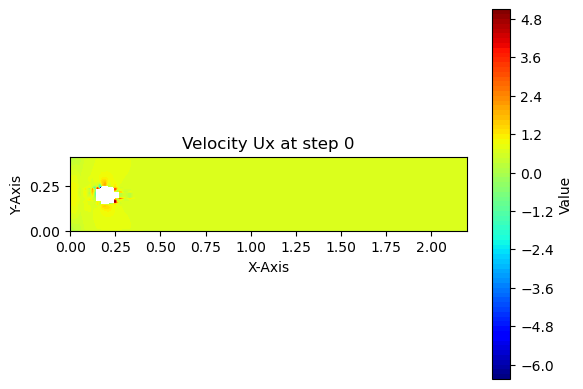

        Newton 1: |R|_∞ = 6.17e-02
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 8.29e-02
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.42e-02
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 9.76e-03
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 9.85e-04
        Armijo search accepted α = 1.00e+00
        Newton 6: |R|_∞ = 2.32e-05
        Armijo search accepted α = 1.00e+00
        Newton 7: |R|_∞ = 1.87e-08
    Time step 2: ΔU = 1.08e+11
Solution exported to turek_results/solution_0001.vtu
[step    1]  FD=-5.247036e-02  FL=-1.042474e-01  CD=-1.049407  CL=-2.084949  Δp=1.693613
        Newton 1: |R|_∞ = 9.42e-02
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 8.06e-02
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.12e-02
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 2.58e-03
        Armijo search accepted α = 1.00e+00
  

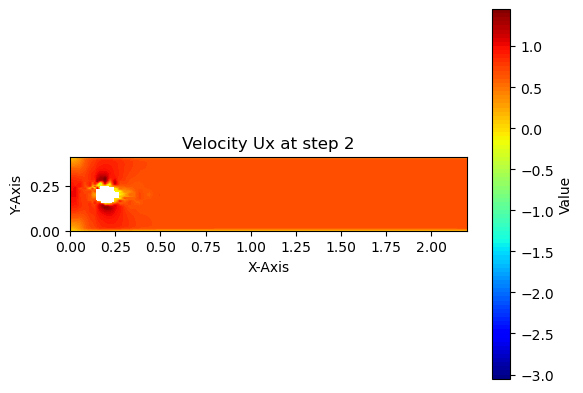

        Newton 1: |R|_∞ = 6.05e-02
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.92e-02
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.17e-03
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 3.20e-05
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 7.68e-09
    Time step 4: ΔU = 2.41e+10
Solution exported to turek_results/solution_0003.vtu
[step    3]  FD=-8.802311e-02  FL=2.145210e-02  CD=-1.760462  CL=0.429042  Δp=0.965710
        Newton 1: |R|_∞ = 4.96e-02
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.65e-02
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 8.66e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 2.37e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 3.21e-11
    Time step 5: ΔU = 2.42e+10
Solution exported to turek_results/solution_0004.vtu
[step    4]  FD=-4.026077e-02  FL=5.163661e

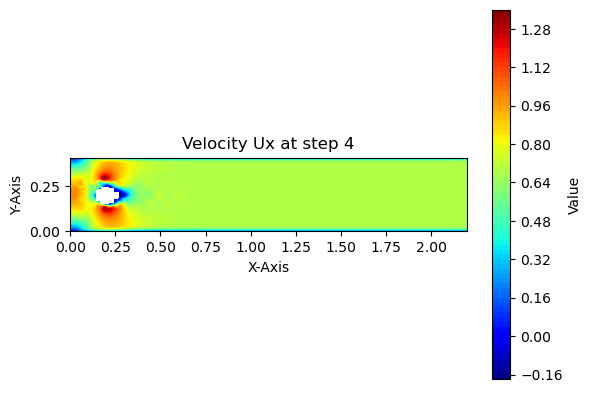

        Newton 1: |R|_∞ = 3.97e-02
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 9.27e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.78e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 2.75e-07
    Time step 6: ΔU = 1.78e+10
Solution exported to turek_results/solution_0005.vtu
[step    5]  FD=-7.310227e-02  FL=-1.020209e-02  CD=-1.462045  CL=-0.204042  Δp=0.799534
        Newton 1: |R|_∞ = 3.40e-02
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 6.26e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.25e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 9.41e-08
    Time step 7: ΔU = 1.59e+10
Solution exported to turek_results/solution_0006.vtu
[step    6]  FD=-3.054953e-02  FL=5.840048e-02  CD=-0.610991  CL=1.168010  Δp=0.698127
Plotting component: 'ux'


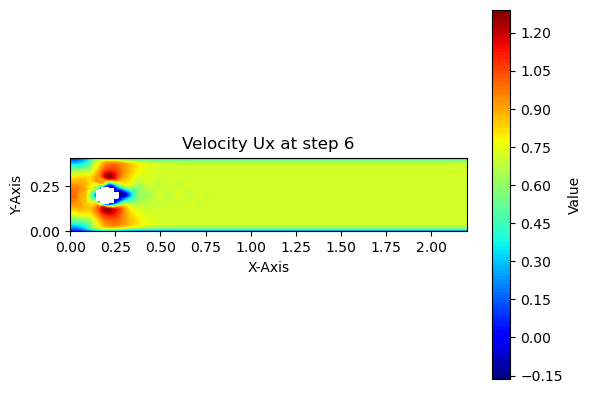

        Newton 1: |R|_∞ = 2.92e-02
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.39e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.25e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 6.23e-09
    Time step 8: ΔU = 1.96e+10
Solution exported to turek_results/solution_0007.vtu
[step    7]  FD=-1.228092e-01  FL=-5.628280e-02  CD=-2.456184  CL=-1.125656  Δp=0.859983
        Newton 1: |R|_∞ = 2.54e-02
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.55e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.70e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 2.54e-09
    Time step 9: ΔU = 3.22e+10
Solution exported to turek_results/solution_0008.vtu
[step    8]  FD=4.734903e-02  FL=1.537691e-01  CD=0.946981  CL=3.075383  Δp=0.824659
Plotting component: 'ux'


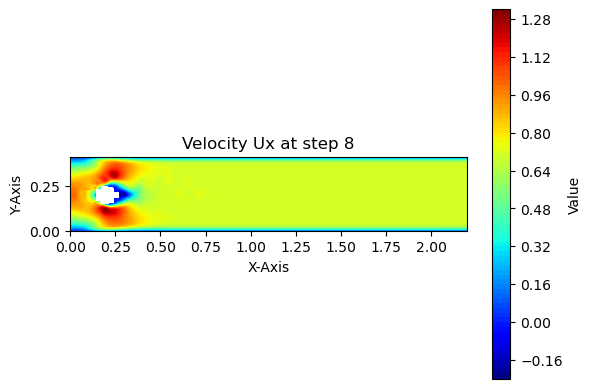

        Newton 1: |R|_∞ = 2.21e-02
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.38e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.09e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 7.45e-10
    Time step 10: ΔU = 6.15e+10
Solution exported to turek_results/solution_0009.vtu
[step    9]  FD=-3.067389e-01  FL=-2.539735e-01  CD=-6.134778  CL=-5.079471  Δp=0.926896
        Newton 1: |R|_∞ = 1.94e-02
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.59e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.17e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 6.66e-09
    Time step 11: ΔU = 1.20e+11
Solution exported to turek_results/solution_0010.vtu
[step   10]  FD=4.055641e-01  FL=5.592276e-01  CD=8.111282  CL=11.184552  Δp=0.899035
Plotting component: 'ux'


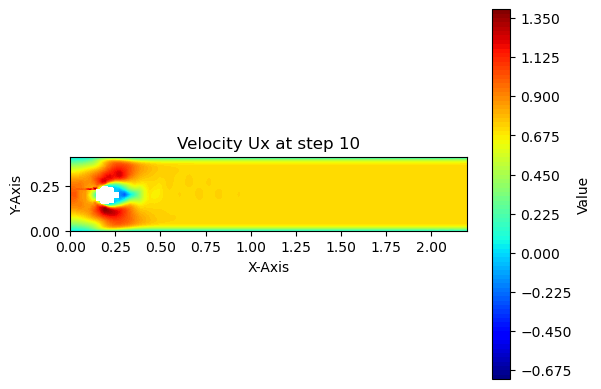

        Newton 1: |R|_∞ = 1.71e-02
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 4.38e-03
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 8.70e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 8.45e-08
    Time step 12: ΔU = 2.57e+11
Solution exported to turek_results/solution_0011.vtu
[step   11]  FD=-1.049707e+00  FL=-1.072899e+00  CD=-20.994148  CL=-21.457989  Δp=0.927902
        Newton 1: |R|_∞ = 1.50e-02
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.05e-02
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 7.12e-04
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 5.16e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 3.96e-10
    Time step 13: ΔU = 5.07e+11
Solution exported to turek_results/solution_0012.vtu
[step   12]  FD=1.898086e+00  FL=2.229409e+00  CD=37.961720  CL=44.588184  Δp=0.908290
Plotting component: 'ux'


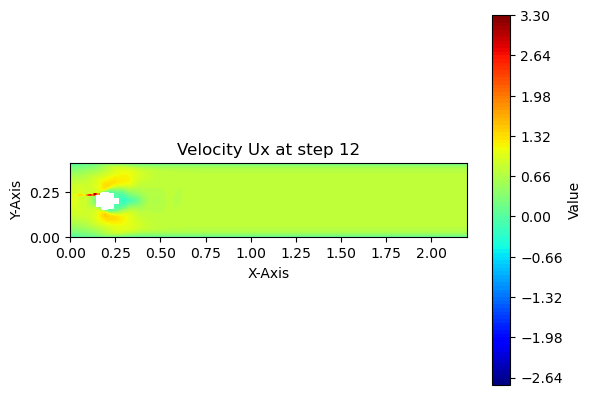

        Newton 1: |R|_∞ = 2.40e-02
        Armijo search accepted α = 5.00e-01
        Newton 2: |R|_∞ = 2.57e-02
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.36e-02
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.26e-03
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 2.44e-05
        Armijo search accepted α = 1.00e+00
        Newton 6: |R|_∞ = 3.09e-09
    Time step 14: ΔU = 1.36e+12
Solution exported to turek_results/solution_0013.vtu
[step   13]  FD=-3.928158e+00  FL=-4.225802e+00  CD=-78.563168  CL=-84.516030  Δp=0.704346
        Newton 1: |R|_∞ = 4.97e-02
        Armijo search accepted α = 2.50e-01
        Newton 2: |R|_∞ = 3.78e-02
        Armijo search accepted α = 5.00e-01
        Newton 3: |R|_∞ = 3.63e-02
        Armijo search accepted α = 5.00e-01
        Newton 4: |R|_∞ = 2.35e-02
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 3.55e-02
        Armijo search accepted α = 1.00e+00

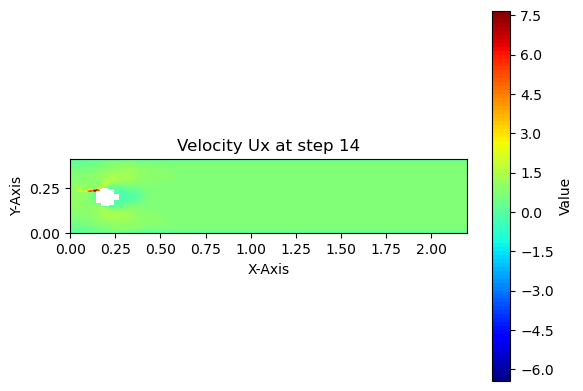

        Newton 1: |R|_∞ = 2.13e-01
        Armijo search accepted α = 1.25e-01
        Newton 2: |R|_∞ = 2.21e-01
        Armijo search accepted α = 1.25e-01
        Newton 3: |R|_∞ = 2.19e-01
        Armijo search accepted α = 2.50e-01
        Newton 4: |R|_∞ = 2.19e-01
        Armijo search accepted α = 5.00e-01
        Newton 5: |R|_∞ = 8.21e-02
        Armijo search accepted α = 5.00e-01
        Newton 6: |R|_∞ = 4.23e-02
        Armijo search accepted α = 1.00e+00
        Newton 7: |R|_∞ = 4.32e-02
        Armijo search accepted α = 1.00e+00
        Newton 8: |R|_∞ = 3.86e-03
        Armijo search accepted α = 1.00e+00
        Newton 9: |R|_∞ = 4.71e-04
        Armijo search accepted α = 1.00e+00
        Newton 10: |R|_∞ = 2.28e-06
        Armijo search accepted α = 1.00e+00
        Newton 11: |R|_∞ = 9.59e-11
    Time step 16: ΔU = 1.05e+13
Solution exported to turek_results/solution_0015.vtu
[step   15]  FD=-1.139069e+01  FL=-1.213794e+01  CD=-227.813774  CL=-242.758870  Δp=0.20

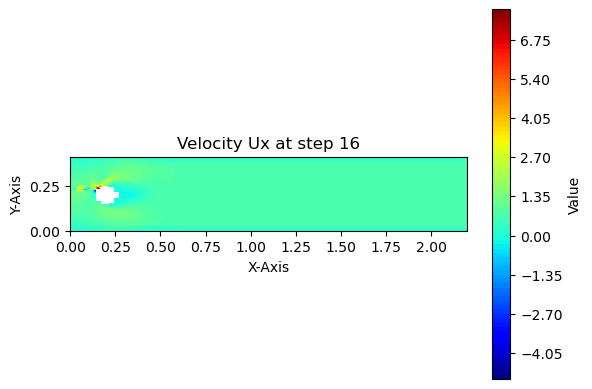

        Newton 1: |R|_∞ = 2.53e+00
        Armijo search accepted α = 1.25e-01
        Newton 2: |R|_∞ = 2.41e+00
        Armijo search accepted α = 1.25e-01
        Newton 3: |R|_∞ = 2.29e+00
        Armijo search accepted α = 1.25e-01
        Newton 4: |R|_∞ = 2.16e+00
        Armijo search accepted α = 2.50e-01
        Newton 5: |R|_∞ = 2.13e+00
        Armijo search accepted α = 5.00e-01
        Newton 6: |R|_∞ = 8.22e-01
        Armijo search accepted α = 1.00e+00
        Newton 7: |R|_∞ = 3.95e-01
        Armijo search accepted α = 7.81e-03
        Newton 8: |R|_∞ = 3.92e-01
        Armijo search accepted α = 6.25e-02
        Newton 9: |R|_∞ = 3.69e-01
        Armijo search accepted α = 1.25e-01
        Newton 10: |R|_∞ = 3.23e-01
        Armijo search accepted α = 2.50e-01
        Newton 11: |R|_∞ = 2.45e-01
        Armijo search accepted α = 3.12e-02
        Newton 12: |R|_∞ = 2.38e-01
        Armijo search accepted α = 7.81e-03
        Newton 13: |R|_∞ = 2.36e-01
        Armij

RuntimeError: Newton did not converge – adjust Δt or verify Jacobian.

In [16]:
from pycutfem.solvers.nonlinear_solver import (NewtonSolver, 
                                               NewtonParameters, 
                                               TimeStepperParameters, 
                                               AdamNewtonSolver,
                                               PetscSnesNewtonSolver)
from pycutfem.solvers.aainhb_solver import AAINHBSolver           # or get_solver("aainhb")


# build residual_form, jacobian_form, dof_handler, mixed_element, bcs, bcs_homog …
time_params = TimeStepperParameters(dt=dt.value,max_steps=50 ,stop_on_steady=True, steady_tol=1e-6, theta= theta.value)
dirichlet_dofs = set(dof_handler.get_dirichlet_data(bcs).keys())  # bcs = your Dirichlet BCs
post_cb = make_peak_filter_cb(
    dof_handler, level_set,
    fields=("ux","uy"),      # or ("ux","uy","p") if you want to smooth pressure too
    side='+',                 # use '+' if Ω = {φ>0}, '-' if Ω = {φ<0}
    band_width=0.5,           # in units of h
    tau=5.0,
    skip_dofs=dirichlet_dofs
)

solver = NewtonSolver(
    residual_form, jacobian_form,
    dof_handler=dof_handler,
    mixed_element=mixed_element,
    bcs=bcs, bcs_homog=bcs_homog,
    newton_params=NewtonParameters(newton_tol=1e-6, line_search=True),
    postproc_timeloop_cb=save_solution,
    # preproc_cb=post_cb,  # Optional: peak filter callback
)
# Unconstrained Newton (fast, robust)
# solver = PetscSnesNewtonSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6, line_search=False, max_newton_iter=60), # Line search handled by PETSc
#     postproc_timeloop_cb=save_solution,
#     petsc_options={
#         # --- SNES (Nonlinear Solver) Options ---
#         "snes_type": "newtonls",
#         "snes_linesearch_type": "bt",
#         "snes_converged_reason": None,
#         "snes_monitor": None,
        
#         # --- KSP (Linear Solver) and PC (Preconditioner) Options ---
#         "ksp_type": "gmres",  # A flexible iterative solver is best for fieldsplit
#         "pc_type": "fieldsplit",
#         "pc_fieldsplit_type": "schur",
        
#         # Configure the Schur factorization
#         # 'full' is most robust: S = C - B*inv(A)*B.T
#         "pc_fieldsplit_schur_fact_type": "full",

#         # --- Sub-solvers for the Velocity block (u) ---
#         # We'll use a direct solver (MUMPS) for the momentum block inv(A)
#         # This is often referred to as "ideal" Schur complement.
#         "fieldsplit_u_ksp_type": "preonly",
#         "fieldsplit_u_pc_type": "lu",
#         "fieldsplit_u_pc_factor_mat_solver_type": "mumps",

#         # --- Sub-solvers for the Pressure block (the Schur complement S) ---
#         # The solve on S is often approximate. We use GMRES + a simple PC.
#         "fieldsplit_p_ksp_type": "gmres",
#         "fieldsplit_p_pc_type": "hypre",   # Use Hypre's BoomerAMG 
#         "fieldsplit_p_ksp_rtol": 1e-5,
#     },
# )

# 2. Define the field splitting for the Schur complement
# This tells the solver how to partition the system.
# solver.set_schur_fieldsplit(
#     split_map={
#         'u': ['ux', 'uy'],  # The 'A' block in the matrix
#         'p': ['p'],         # The 'C' block (and where S operates)
#     }
# )

# VI solver (semismooth; we’ll run it for only 1–2 iterations per step)
# vi = PetscSnesNewtonSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler, mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6, line_search=True),
#     postproc_timeloop_cb=save_solution,
#     petsc_options={
#         "snes_type": "vinewtonssls",      # semismooth VI is robust near kinks
#         "snes_linesearch_type": "bt",
#         "snes_vi_monitor": None,          # optional: see active set
#         "ksp_type": "preonly", "pc_type": "lu",
#         "pc_factor_mat_solver_type": "mumps",
#     },
# )
# # Cap |u| only in a narrow band around the interface on φ>=0 (fluid) side
# Ucap = 4.0 * U_mean        # pick something physically reasonable
# vi.set_vi_on_interface_band(
#     level_set,
#     fields=("ux", "uy"),
#     side="+",
#     band_width=0.5,               # ~ one h around interface
#     bounds_by_field={"ux": (-Ucap, Ucap), "uy": (-Ucap, Ucap)},
# )
# primary unknowns
functions      = [u_k, p_k]
prev_functions = [u_n, p_n]
# solver = AdamNewtonSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6)
# )
# solver = AAINHBSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6),
# )
from petsc4py import PETSc
def vi_clip(step, bcs_now, funs, prev_funs):
    if step < 1:
        return

    vi._ensure_snes(len(vi.active_dofs), PETSc.COMM_WORLD)

    # ---- project current state into the box and write back to fields ----
    # assemble the reduced current guess from the fields
    x0_full = np.hstack([f.nodal_values for f in funs]).copy()
    x0_red  = x0_full[vi.active_dofs].copy()

    if getattr(vi, "_XL", None) is not None and getattr(vi, "_XU", None) is not None:
        lo = vi._XL.getArray(readonly=True)
        hi = vi._XU.getArray(readonly=True)
        x0_red = np.minimum(np.maximum(x0_red, lo), hi)

        # write the projected state back to the fields (absolute assign)
        new_full = x0_full
        new_full[vi.active_dofs] = x0_red
        for f in funs:
            g = f._g_dofs
            f.set_nodal_values(g, new_full[g])
        vi.dh.apply_bcs(bcs_now, *funs)

    # ---- short VI solve (1–2 steps is usually enough) ----
    old = vi._snes.getTolerances()
    vi._snes.setTolerances(rtol=0.0, atol=vi.np.newton_tol, max_it=2)
    _ = vi._newton_loop(funs, prev_funs, aux_funcs=None, bcs_now=bcs_now)
    vi._snes.setTolerances(*old)



solver.solve_time_interval(functions=functions,
                           prev_functions= prev_functions,
                           time_params=time_params,
                           # post_step_refiner=vi_clip
                           )

In [ ]:
plt.plot(histories["cd"], label="C_D", marker='o')
plt.ylabel('C_D')
plt.figure()
plt.plot(histories["cl"], label="C_L", marker='o')
plt.ylabel('C_L')
plt.figure()
plt.plot(histories["dp"], label="Δp", marker='o')
plt.ylabel('Δp')

In [ ]:


u_n.plot(kind="contour",mask =fluid_domain,
         title="Turek-Schafer",
         xlabel='X-Axis', ylabel='Y-Axis',
         levels=100, cmap='jet')

In [ ]:
p_n.plot(
         title="Pressure",mask =fluid_domain)